# VQE aplicado a Job Reassignment Problem (JRP)

## Bibliografía

[PennyLane CodeMap: Introduction to Variational Quantum Algorithms (VQA)](https://pennylane.ai/codebook/variational-quantum-algorithms/parametrized-quantum-circuits): Puede venir bien por si hay algunas dudas de conceptos fundamentales

[PennyLane CodeMap: VQE](https://pennylane.ai/codebook/variational-quantum-algorithms/variational-quantum-eigensolver): Explicación Teórica + Ejercicios de Programación para practicar la implementación

[Ket-G: Hamiltoniano](https://www.youtube.com/watch?v=OXthrvvLhDw): Explicación teórica

[Ket-G: VQE](https://www.youtube.com/watch?v=dDVkAgU7hbo): Explicación Teórica

[Ket-G: Programando el algoritmo VQE](https://www.youtube.com/watch?v=jFTKKJ1sIaE): Implementación del algoritmo VQE

[Formulación QUBO para el Job Reassignment Problem](https://arxiv.org/pdf/2309.16473): Explicación del JRP, su formulación QUBO y pseudocódigo

In [1]:
# INDICAR SI ESTAMOS EN COLAB O NO (JUPYTER POR EJEMPLO)
colab = False
if colab:
    !pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
import random
import networkx as nx

## 0. Introducción

Tenemos $J$ máquinas, personas... Los llamaremos *agentes*, que actualmente están desarrollando un trabajo concreto cada uno. Sin embargo, debido a circunstancias inesperadas, hay $I$ trabajos ahora mismo vacantes que no tienen un agente asociado. El objetivo encontrar los agentes que mejor encajan en los trabajos tanto vacantes como ocupados actualmente (en total $J + I = K$ trabajos), y moverlos de los ocupados a los vacantes si fuera necesario. 

Definimos una lista de trabajos actualmente ocupados $[a_j]$ y una lista $[P_j^C]$ con sus prioridades asociadas. De igual forma, definimos $[v_i]$ y $[P_i^V]$ con los vacantes. También existe una matriz que la llamaremos $(A_{kj})$ de tamaño $K \times J$ en donde el elemento $a_{ij}$ representa la afinidad del trabajador $j$ (que no confundir con el trabajo que está ocupando actualmente) con el trabajo $i$ (sea de los inicialmente ocupados o de los vacantes). 

Ahora podemos definir para cada par $(i,j)$ donde $i$ es un trabajo vacante y $j$ uno ocupado una puntuación $S_{ij}$:

$$
s_{ij} = c^P \Delta_{ij}^P + c^A \Delta_{ij}^A = c^P (P_i^V - P_j^C) + c^A (A_{ij}^V-A_{jj}^C)
$$

donde la primera resta es la ganancia/pérdida de prioridad y el segundo la ganancia/pérdida de afinidad. $c^P$ y $c^A$ son coeficientes que regulan estos términos. Lo que buscamos es maximizar estos términos (para que se sustituyan trabajos "malos" por otros "buenos").

Las variables de nuestro problema son $x_{ij}$, que si valen $1$ entonces se cambia el trabajo $j$ por el $i$. Entonces ya podemos definir nuestro Hamiltoniano a minimizar así:

$$
H = - \sum_{ij} \bigg[ c^P (P_i^V - P_j^C) + c^A(A_{ij}^V-A_{jj}^C) \bigg]x_{ij} + \lambda_1 \sum_i \bigg( \sum_j x_{ij}-0.5 \bigg)^2 + \lambda_2 \sum_j \bigg( \sum_i x_{ij}-0.5 \bigg)^2
$$

El primer término es la función a maximizar (pero el signo cambiado para minimizar) y los otros dos términos son restricciones, de forma que la primera restricción es para que cada trabajo $i$ sea realizado como mucho por un agente, y la segunda restricción es para que cada agente $j$ al final sólo haga un trabajo (poner números más bien elevados para los coeficientes $\lambda$ que se cumpla). El término $0.5$ es para que la suma de variables sea o $0$ o $1$. 

El problema puede tener valores de prioridades y afinidades discretos o continuos, pero en ambos casos realizamos una división del problema en D subproblemas, resolviendo primero los subproblemas con trabajos vacantes con prioridades altas. En caso de tener valores discretos, es muy cómodo tener por ejemplo $D=5$ porque pueden ser como las valoraciones con 5 estrellitas. En cualquier caso, se pueden tener otras divisiones tanto en el caso continuo como en el discreto. 

Además, en cada subproblema, antes de aplicar el algoritmo VQE, reducimos la dimensionalidad de cada subproblema aplicando la lógica para eliminar posibles cambios que no tienen sentido por empeorar la situación en la que nos encontremos. 

## 1. Definición de Inputs

Definimos una función que crea los inputs a este problema: las listas de los trabajos ocupados y vacantes y sus respectivas prioridades y la matriz de afinidades (y otros objetos para que nos sea todo más cómodo). 

In [2]:
# np.random.seed(7)
def inicialización(tipo, J, I, D, PC_j_user = None, PV_i_user = None, A_kj_user = None):
    
    # K: Nº de trabajos totales 
    K = I + J
    
    # a_j: Lista tal que el agente j está asignado al trabajo a_j[j]
    a_j = list(range(J))

    # {P_j}^C: Lista con prioridades de los trabajos a_j
    
    # Inicialización aleatoria DISCRETA
    if tipo == "discreto":
        PC_j = [int(num) for num in np.random.randint(1, D+1, size = J)]
        
    # Inicialización aleatoria CONTINUA (como np.random.random devuelve nº en [0,1) y tiene que ser (0,1] )
    elif tipo == "continuo":
        PC_j = [1 - float(num) for num in np.random.random(J)]
        
    # Inicialización voluntaria
    else:
        PC_j = PC_j_user
        
    
    # v_i = lista con los I trabajos vacantes.
    v_i = list(range(J,K))

    
    # {P_V}^i: Prioridades de los v_i trabajos
    
    # Inicialización aleatoria DISCRETA 
    if tipo == "discreto":
        PV_i = [int(num) for num in np.random.randint(1, D+1, size = I)]
        
    # Inicialización aleatoria CONTINUA (como np.random.random devuelve nº en [0,1) y tiene que ser (0,1]
    elif tipo == "continuo":
        PV_i = [1 - float(num) for num in np.random.random(I)]
        
    # Inicialización voluntaria
    else:
        PV_i = PV_i_user

    
    # A_kj = Afinidades entre cada agente j y cada trabajo k
    
    # Inicialización aleatoria DISCRETA
    if tipo == "discreto":
        A_kj = np.random.randint(1, D+1, size = (K, J))
        
    # Inicialización aleatoria CONTINUA
    elif tipo == "continuo":
        A_kj = 1 - np.random.random_sample((K, J)) 
        
    # Inicialización voluntaria
    else:
        A_kj = A_kj_user

    
    # En cualquier caso, vamos a crear un diccionario con todos los K = I + J trabajos y sus respectivas prioridades
    dict_trab_prior = dict(zip(a_j, PC_j)) | dict(zip(v_i, PV_i))
    print(dict_trab_prior)

    return K, a_j, PC_j, v_i, PV_i, A_kj, dict_trab_prior

# I: Nº de trabajos vacantes
# J: Nº de trabajos ocupados ( = Nº agentes)
I = 6
J = 6
    
# D: Nº de subdivisiones del problema 
    # En caso discreto = prioridad máxima
D = 5

# cP, cA son los coeficientes de los pesos relativos de los términos de prioridad y afinidad del Hamiltoniano (B.3)
cP = 10
cA = 10

# Si queremos el problema "discreto", "continuo", o "personalizado"
tipo = "continuo"

# En caso de que el usuario quiera inicializar por sí mismo los valores
#PC_j_user = # RELLENAR LISTA
#PV_i_user = # RELLENAR LISTA
#A_kj_user = # RELLENAR NP.MATRIX

# K, a_j, PC_j, v_i, PV_i, A_kj, dict_trab_prior = inicialización(tipo, J, I, D)
# print("a_j: ",a_j)
# print("PC_j: ", PC_j)
# print("v_i: ", v_i)
# print("PV_i: ", PV_i)
# #print("A_kj: ", A_kj)
# print("dict_trab_prior: ", dict_trab_prior)

## 2. Procedimiento 

### A. División de lista de trabajos vacantes $[v_i]$ en D sublistas

En primer lugar, dividimos el conjunto de trabajos vacantes en sublistas según sus prioridades.

#### Caso 1. Si las prioridades son continuas
Creamos intervalos de longitud igual entre 0 y 1. Para ello se utiliza para $d = 0,..., D-1$

$$
1-\frac{d}{D} \ge P_i^V \ge 1-\frac{d + 1}{D}
$$

Atención, porque las prioridades más altas estarán en el grupo $1$, y las más bajas en el $D$ (porque iremos resolviendo los subproblemas en orden ascendente y queremos asignar primero los trabajos más importantes).

#### Caso 2. Si las prioridades son discretas
Simplemente las agrupamos por prioridad pero al revés (resolvemos primero las que más prioridad tienen pero que están en el primer grupo).

In [3]:
# Caso CONTINUO
def crear_dict_D_sublistas_continuo(D, dict_trab_prior, v_i):

    # Primero, creamos un diccionario donde alojaremos las D sublistas
    dict_D_sublistas = dict()
    
    # Calculamos los límites de las categorías, que son 1-0/D = 1, 1-1/D, 1-2/D ... 1-D/D = 0
    limites = [1-i/D for i in range(0,D+1)]
    
    # Para cada valor de 0 a D-1
    for d in range(0, D):

        # Cogemos el máximo y el mínimo
        tope_arriba = limites[d]
        tope_abajo = limites[d+1]
    
        # Creamos la sublista en el diccionario
        dict_D_sublistas[d + 1] = [item for item in v_i if tope_arriba >= dict_trab_prior[item] > tope_abajo]

    return limites, dict_D_sublistas

# Caso DISCRETO
def crear_dict_D_sublistas_discreto(D, dict_trab_prior, v_i):

    # Primero, creamos un diccionario donde alojaremos las D sublistas
    dict_D_sublistas = dict()

    # Para cada valor de 0 a D-1
    for d in range(0, D):

        #dict_D_sublistas[d+1] = [item for item in v_i if dict_trab_prior[item] == d + 1]
        dict_D_sublistas[d+1] = [item for item in v_i if dict_trab_prior[item] == D - d]
    return dict_D_sublistas

# Si las prioridades son CONTINUAS
# limites_sublistas, dict_D_sublistas = crear_dict_D_sublistas_continuo(D, dict_trab_prior, v_i)
# print(limites_sublistas, dict_D_sublistas)

# Si las prioridades son DISCRETAS
#dict_D_sublistas = crear_dict_D_sublistas_discreto(D, dict_trab_prior, v_i)
#print(dict_D_sublistas)

### B. Iteraciones

Para $\delta \in \{1,...,D\}$, repetir los siguientes pasos:

#### B.1 Primer filtro

Como sólo pueden ocurrir cambios tales que $\Delta_{ij}^P = P_i^V - P_j^C > 0$ (es decir, que la prioridad de los trabajos ocupados sea menor a las de las vacantes), podemos crear una sublista $[a_j]_\delta$ con trabajos ocupados por el momento tales que $p_j^C < p_{\delta}^Vmax$. 

In [4]:
# CASO CONTINUO Y DISCRETO
# delta = 5
def filtro_prioridades(dict_D_sublistas, lista_a_j, dict_trab_prior, delta):

    # Primero, hallamos la prioridad más alta de aquellas relacionadas con la lista delta
    max_pV_delta = max([dict_trab_prior[vacante] for vacante in dict_D_sublistas[delta]])

    # Nos quedamos con aquellos trabajos actualmente ocupados tales que son menores a este valor
    return [trabajo_actual for trabajo_actual in lista_a_j if dict_trab_prior[trabajo_actual] < max_pV_delta]

# sublista_a_j = filtro_prioridades(dict_D_sublistas, a_j, dict_trab_prior, delta)
# print(sublista_a_j)

#### B.2 Conectar elementos actuales con elementos vacantes

Vamos a considerar todas aquellas posibles conexiones entre elementos de $[a_j]_\delta$ con elementos de $[v_i]_\delta$. Luego, quitaremos aquellas conexiones tales que $s_{ij} \leq 0 \rightarrow c^P \Delta_{ij}^P + c^A \Delta_{ij}^A \leq 0 \rightarrow c^P (P_i^V - P_j^C) + c^A (A_{ij}^V-A_{jj}^C) \leq 0$ (porque nos llevarían a una peor solución del problema; recordar que queremos maximizar los valores $s_{ij}$)


In [5]:
# Caso DISCRETO y CONTINUO
def crear_combinaciones(a_j, sublista_a_j, dict_D_sublistas, dict_trab_prior, A_kj, delta):
    
    # Primero, creamos la lista donde iremos alojando los pares
    lista_pares = []

    # Nos quedamos con la lista de v_i correspondiente
    lista_v_i = dict_D_sublistas[delta]

    # Para cada posible par ocupado - vacante
    for trabajo_a_j in sublista_a_j:
        for trabajo_v_i in lista_v_i:
            # Hacemos el cálculo de la expresión, y si es mayor que cero, lo añadimos a la lista
            primer_termino = dict_trab_prior[trabajo_v_i] - dict_trab_prior[trabajo_a_j]
            segundo_termino = A_kj[trabajo_v_i][a_j.index(trabajo_a_j)] - A_kj[trabajo_a_j][a_j.index(trabajo_a_j)]
            if cP * (primer_termino) + cA * (segundo_termino) > 0:
                lista_pares.append((trabajo_v_i, trabajo_a_j))

    return lista_pares

# combinaciones_delta = crear_combinaciones(a_j, sublista_a_j, dict_D_sublistas, dict_trab_prior, A_kj, delta)
# print(combinaciones_delta)

#### B.3 Hallar el mínimo del Hamiltoniano asociado a nuestras combinaciones

Ahora creamos un circuito cuántico en el que tenemos tantas variables (cubits) como combinaciones hayamos obtenido en el paso anterior. 

El Hamiltoniano a resolver es el siguiente:

$$
H = - \sum_{ij} \bigg[ c^P (P_i^V - P_j^C) + c^A(A_{ij}^V-A_{jj}^C) \bigg]x_{ij} + \lambda_1 \sum_i \bigg( \sum_j x_{ij}-0.5 \bigg)^2 + \lambda_2 \sum_j \bigg( \sum_i x_{ij}-0.5 \bigg)^2
$$

Vamos a desarrollar cada término realizando la conversión $x_{ij} = \frac{1-z_{ij}}{2}$ para estar en modelo Ising:

##### Primer término
$$
-\sum_{ij} \bigg[ c^P (P_i^V - P_j^C) + c^A(A_{ij}^V-A_{jj}^C) \bigg]x_{ij} = -\sum_{ij} \bigg[ c^P (P_i^V - P_j^C) + c^A(A_{ij}^V-A_{jj}^C) \bigg] \frac{1-z_{ij}}{2}
$$

Ignoramos el $\frac{1}{2}$, quédandonos sólo con el $-\frac{z_{ij}}{2}$, obtenemos
$$
\sum_{ij} \bigg[ c^P (P_i^V - P_j^C) + c^A(A_{ij}^V-A_{jj}^C) \bigg] \frac{z_{ij}}{2}
$$

##### Segundo término (el tercero es por analogía a éste)

$$
\lambda_1 \sum_i \bigg( \sum_j x_{ij}-0.5 \bigg)^2 = \lambda_1 \sum_i \bigg( \sum_{j; (i,j) \in S} \frac{1-z_{ij}}{2} -0.5 \bigg)^2
$$

Definimos $\mathcal{J} = \{ j | (i,j) \in S \}$ y $m_i = | \mathcal{J} |$, es decir, el número de pares para un determinado $i$ tales que el par $(i,j)$ está en $S$. Como $m_i = \bigg(\sum_{j \in \mathcal{J}_i} 1 \bigg)$ e incluyendo el $0.5$ en la fracción, obtenemos

$$
\lambda_1 \sum_i \left( \sum_{j \in \mathcal{J}_i} \frac{1 - z_{ij}}{2} - 0.5 \right)^2 = \lambda_1 \sum_i \left( \frac{m_i - 1 - \sum_{j \in \mathcal{J}_i} z_{ij}}{2} \right)^2
$$

Sacamos el denominador fuera y expandimos el cuadrado

$$
\frac{\lambda_1}{4} \sum_i \left[
(m_i - 1)^2
- 2(m_i - 1) \sum_{j \in \mathcal{J}_i} z_{ij}
+ \left( \sum_{j \in \mathcal{J}_i} z_{ij} \right)^2
\right]
$$

Como $z_{ij}^2 = 1$, se cumple que el último término es equivalente a

$$
\left( \sum_{j \in \mathcal{J}_i} z_{ij} \right)^2 = \sum_j z_{ij}^2 +2 \sum_{j<k}z_{ij}z_{ik} = m_i + 2 \sum_{j<k}z_{ij}z_{ik}
$$

Obtenemos al final

$$
\frac{\lambda_1}{4} \sum_i \left[(m_i - 1)^2 + m_i -2(m_i - 1) \sum_{j \in \mathcal{J}_i} z_{ij}+ 2 \sum_{\substack{j,k \in \mathcal{J}_i \\ j<k}} z_{ij} z_{ik} \right]
$$

Los dos primeros términos del paréntesis son constantes despreciables, entonces nos quedamos con 

$$
\frac{\lambda_1}{4} \sum_i \left[-2(m_i - 1) \sum_{j \in \mathcal{J}_i} z_{ij}+ 2 \sum_{\substack{j,k \in \mathcal{J}_i \\ j<k}} z_{ij} z_{ik} \right] = \sum_i \left[-\frac{\lambda_1(m_i - 1)}{2} \sum_{j \in \mathcal{J}_i} z_{ij}+ \frac{\lambda_1}{2} \sum_{\substack{j,k \in \mathcal{J}_i \\ j<k}} z_{ij} z_{ik} \right]
$$

In [6]:
def vqe(pares, dict_trab_prior, a_j, A_kj, c_P, c_A, lambda1, lambda2, stepsize, steps):
    def construir_hamiltoniano(pares, dict_trab_prior, a_j, A_kj, c_P, c_A, lambda1, lambda2):
        
        # Número total de qubits = número de pares
        n_qubits = len(pares)
        
        # Asociar a cada par (i,j) un índice de qubit (posición en el Hamiltoniano)
        pair_to_index = {pair: idx for idx, pair in enumerate(pares)}
        
        # Listas que almacenarán los coeficientes y los observables del Hamiltoniano
        coeffs = []
        observables = []
    
        # --- Término lineal del coste objetivo ---
        for (i, j) in pares:
            # Índice del qubit correspondiente al par (i,j)
            idx = pair_to_index[(i, j)]
    
            # Obtener la prioridad de i (trabajo V) y j (trabajo C)
            P_i = dict_trab_prior[i]
            P_j = dict_trab_prior[j]
    
            # Obtener el valor A_{ij} y A_{jj} desde la matriz A_kj
            A_ij = A_kj[i, a_j.index(j)]
            A_jj = A_kj[j, a_j.index(j)]
    
            # Calcular el coeficiente asociado al término z_{ij}
            # Recordando que x_{ij} = (1 - z_{ij}) / 2, y descartamos la constante
            coef = 0.5 * (c_P * (P_i - P_j) + c_A * (A_ij - A_jj))
    
            # Solo añadir si el coeficiente no es cero (eficiencia)
            if coef != 0.0:
                coeffs.append(coef)
                observables.append(qml.PauliZ(idx))
    
        # --- Agrupar pares por índice de fila i y por índice de columna j ---
        J_i = defaultdict(list)  # Pares con la misma i
        I_j = defaultdict(list)  # Pares con la misma j
    
        for (i, j) in pares:
            J_i[i].append((i, j))
            I_j[j].append((i, j))
    
        # --- Penalización por filas (i): garantizar que cada i aparece una sola vez ---
        for i, group in J_i.items():
            # Obtener los índices de qubits para los pares con esta i
            indices = [pair_to_index[p] for p in group]
            m = len(indices)  # Número de pares para esta i
    
            # Términos lineales en z_{ij} (provienen del desarrollo del cuadrado)
            for idx in indices:
                coef = -lambda1 * (m - 1) / 2
                coeffs.append(coef)
                observables.append(qml.PauliZ(idx))
    
            # Términos cuadráticos z_{ij} z_{ik} (para j ≠ k)
            for a_idx in range(len(indices)):
                for b_idx in range(a_idx + 1, len(indices)):
                    a = indices[a_idx]
                    b = indices[b_idx]
                    coef = lambda1 / 2
                    coeffs.append(coef)
                    observables.append(qml.PauliZ(a) @ qml.PauliZ(b))
    
        # --- Penalización por columnas (j): garantizar que cada j aparece una sola vez ---
        for j, group in I_j.items():
            # Obtener los índices de qubits para los pares con esta j
            indices = [pair_to_index[p] for p in group]
            m = len(indices)  # Número de pares para esta j
    
            # Términos lineales en z_{ij} (provienen del desarrollo del cuadrado)
            for idx in indices:
                coef = -lambda2 * (m - 1) / 2
                coeffs.append(coef)
                observables.append(qml.PauliZ(idx))
    
            # Términos cuadráticos z_{ij} z_{kj} (para i ≠ k)
            for a_idx in range(len(indices)):
                for b_idx in range(a_idx + 1, len(indices)):
                    a = indices[a_idx]
                    b = indices[b_idx]
                    coef = lambda2 / 2
                    coeffs.append(coef)
                    observables.append(qml.PauliZ(a) @ qml.PauliZ(b))
    
        # Construir y devolver tanto la asignacion de par a cúbit como el Hamiltoniano
        return pair_to_index, qml.Hamiltonian(coeffs, observables)
    
    pair_to_index, H = construir_hamiltoniano(pares, dict_trab_prior, a_j, A_kj, cP, cA, lambda1, lambda2)
    
    # Dispositivo
    n_wires = len(pares)
    dev = qml.device("default.qubit", wires=n_wires)
    
    # Definición del ansatz
    def ansatz(params):
        for i in range(n_wires):
            qml.RY(params[i], wires=i)
        for i in range(n_wires - 1):
            qml.CNOT(wires=[i, i+1])
        for i in range(n_wires):
            qml.RX(params[n_wires+i], wires=i)
    
    # Definición del circuito que ejecuta el ansatz y devuelve el valor esperado según el Hamitoniano
    @qml.qnode(dev)
    def circuit(params):
        ansatz(params)
        return qml.expval(H)
    
    # Función de costo
    def cost(params):
        return circuit(params)
    
    # Inicialización aleatoria
    np.random.seed(42)
    params = np.random.uniform(0, 2*np.pi, size=(2*n_wires,))
    
    # Optimizador
    opt = qml.AdamOptimizer(stepsize = stepsize)
    costs = []
    
    for i in range(steps):
        params = opt.step(cost, params)
        c = cost(params)
        costs.append(round(float(c),4))
        if i % 200 == 0:
            print(f"Step {i} - Cost: {c:.4f}")
        # Si hemos llegado al minimo, para no quemar iteraciones
        if i > 5 and len(set(costs[-5:])) == 1:
            print(i)
            break
            
    #print(costs[-5:])
    # Mostrar resultado
    #print("\nFinal cost:", cost(params))
    #print("Optimal parameters:", params)
    
    # Visualización
    
    plt.plot(costs)
    plt.xlabel("Step")
    plt.ylabel("Cost")
    plt.title("VQE Energy Minimization")
    plt.grid(True)
    plt.show()
    

    # Una vez optimizado nuestro circuito, calculamos las probabilidades de observar las diferentes salidas
    @qml.qnode(dev)
    def probability_circuit(params):
        ansatz(params)
        return qml.probs(wires=range(n_wires))
    
    probs = probability_circuit(params)
    bitstrings = list(product([0, 1], repeat=n_wires))
    
    sorted_results = sorted(zip(probs, bitstrings), reverse=True)
    
    # Me quedo con la opción más probable
    best_solution = sorted_results[0][1]

    # print(best_solution)
    
    # Devuelvo las tuplas asociadas a la solución
    lista_final = []
    for i in range(len(best_solution)):
        if best_solution[i] == 1:
            lista_final.append([key for key, val in pair_to_index.items() if val == i][0])
    
    return lista_final

# lista_cambios = vqe(combinaciones_delta, dict_trab_prior, a_j, A_kj, cP, cA, lambda1 = 10, lambda2 = 10, stepsize = 0.01, steps = 500)
# print(lista_cambios)

##### B.3 Bis Eliminar posibles pares que no cumplan las restricciones

Por si acaso, desarrollamos un método que elimina pares conflictivos de la salida del algoritmo cuántico, manteniendo uno de ellos al azar (al fin y al cabo, sólo puede aparecer cada número una vez en `lista_final` que devuelve la función `vqe`).

In [90]:

"""
def filtrar_pares_sin_repetidos(pares):
    # Crea un diccionario para guardar qué pares se quedan
    candidato_por_elemento = {}

    # Para cada par, lo asociamos a sus elementos
    for a, b in pares:
        for x in (a, b):
            if x not in candidato_por_elemento:
                candidato_por_elemento[x] = []
            candidato_por_elemento[x].append((a, b))

    # Creamos un conjunto de pares válidos
    pares_filtrados = set()

    # Conjunto de elementos que ya hemos asignado
    elementos_usados = set()

    # Vamos a ir seleccionando pares sin conflictos
    for x in list(candidato_por_elemento):
        if x in elementos_usados:
            continue
        candidatos = candidato_por_elemento[x]
        # Eliminamos candidatos con elementos ya usados
        candidatos = [p for p in candidatos if p[0] not in elementos_usados and p[1] not in elementos_usados]
        if candidatos:
            par_escogido = random.choice(candidatos)
            pares_filtrados.add(par_escogido)
            elementos_usados.update(par_escogido)

    return list(pares_filtrados)
"""
def filtrar_pares_sin_repetidos(pares):
    G = nx.Graph()
    G.add_edges_from(pares)
    
    # Encontrar el conjunto de pares máximo sin elementos repetidos
    matching = list(nx.max_weight_matching(G, maxcardinality=True))

    # Para asegurarnos que seguimos el orden
    resultado = []
    for tupla in matching:
        if tupla in resultado:
            resultado.append(tupla)
        else:
            resultado.append((tupla[1], tupla[0]))
                             
    return resultado

#### B.4 Actualizar lista de trabajos ocupados y vacantes

Ahora actualizamos la lista de trabajos ocupados y sus prioridades relacionadas. Cambiamos el antiguo trabajo por el nuevo trabajo (en ambas listas), poniendo el elemento que entra en la misma posición del elemento que se va.

In [8]:
def cambios_trabajos(lista_cambios, lista_a_j, lista_v_i, diccionario_trab_prior, lista_PC_j, lista_PV_i):
    # Para cada cambio
    for cambio in lista_cambios:
        # Nuevo, antiguo
        nuevo = cambio[0]
        antiguo = cambio[1]
        # Averiguamos el índice de cada uno en sus respectivas listas
        antiguo_index = lista_a_j.index(antiguo)
        nuevo_index = lista_v_i.index(nuevo)
        # Averiguamos las prioridades de cada uno
        antiguo_prior = diccionario_trab_prior[antiguo]
        nuevo_prior = diccionario_trab_prior[nuevo]
        # Actualizamos las listas
        lista_a_j[antiguo_index] = nuevo
        lista_PC_j[antiguo_index] = nuevo_prior

        lista_v_i[nuevo_index] = antiguo
        lista_PV_i[nuevo_index] = antiguo_prior
        
    return lista_a_j, lista_PC_j, lista_v_i, lista_PV_i
    
# a_j, PC_j, v_i, PV_i = cambios_trabajos(lista_cambios, prueba_a_j, prueba_v_i, dict_trab_prior, prueba_PC_j, prueba_PV_i)
# print(a_j)
# print(PC_j)
# print(v_i)
# print(PV_i)

#### B.5 Actualizar las sublistas $[v_i]_\delta$

Tenemos que actualizar todas las listas $[v_i]_\delta$ con $\delta \in \{\delta + 1,...,D\}$ (las de las siguientes iteraciones) para incluir los trabajos que ahora han quedado vacantes. 

En el caso discreto, tenemos que localizar el grupo específico que le corresponde según su prioridad.

En el caso continuo, podría ocurrir que su prioridad le haga estar en el grupo correspondiente a la iteración $\delta$ que se acaba de hacer. Como hay que incluirla en alguno de los siguientes grupos, lo incluimos en el siguiente grupo (correspondiente a $\delta + 1$).

No creo que haga falta quitar el elemento antes vacante y ahora ocupado porque a partir de ahora sólo miraremos las listas de $\delta+1$ hasta $D$, y como el elemento en cuestión está en la lista $\delta$...

In [9]:
# Caso DISCRETO
def actualizar_sublistas_discreto(lista_cambios, dict_trab_prior, dict_D_sublistas, delta):
    # Para cada cambio en la lista
    for cambio in lista_cambios:

        # Me quedo con el antiguo y su prioridad
        antiguo = cambio[1]
        antiguo_prior = dict_trab_prior[antiguo]

        # Vamos al diccionario de sublistas, añadimos el trabajo a la sublista asociada a la prioridad
        dict_D_sublistas[antiguo_prior].append(antiguo)
        
    return dict_D_sublistas
        
# Caso CONTINUO
def actualizar_sublistas_continuo(lista_cambios, dict_trab_prior, limites_sublistas, dict_D_sublistas, delta):
    # Para cada cambio en la lista
    for cambio in lista_cambios:

        # Me quedo con el antiguo y su prioridad
        antiguo = cambio[1]
        antiguo_prior = dict_trab_prior[antiguo]
        
        # Miramos en qué intervalo está según limites_sublistas
        # Las claves del diccionario (aquí son etiquetas de intervalos) son 1,...,D
        intervalo = delta 
        for d in range(delta - 1, D - 1):
            limite_inf = limites_sublistas[d+1]
            limite_sup = limites_sublistas[d]
            #print(intervalo, limite_sup, limite_inf)
            #print("inf < antiguo_prior -> ", limite_inf," < ",antiguo_prior,": ",limite_inf < antiguo_prior)
            #print("antiguo_prior <= sup -> ", antiguo_prior," <= ",limite_sup,": ", antiguo_prior <= limite_sup)
            if limite_inf < antiguo_prior and antiguo_prior <= limite_sup:
                break
            intervalo += 1
        
        # Si el intervalo es que hemos hecho esta iteración, lo metemos en la siguiente
        if intervalo == delta:
            dict_D_sublistas[intervalo + 1].append(antiguo)

        # En otro caso
        else:
            dict_D_sublistas[intervalo].append(antiguo)
            
    return dict_D_sublistas
        
# Si es caso DISCRETO
# dict_D_sublistas = actualizar_sublistas_discreto(lista_cambios, dict_trab_prior, dict_D_sublistas, delta)

# Si es caso CONTINUO
# dict_D_sublistas = actualizar_sublistas_continuo(lista_cambios, dict_trab_prior, limites_sublistas, dict_D_sublistas, delta)

### C. Llamada a las funciones
Ahora tenemos que montar la función completa, que hace estos pasos anteriores 

{0: 3, 1: 1, 2: 2, 3: 4, 4: 1, 5: 1, 6: 1, 7: 4, 8: 3, 9: 4}
a_j:  [0, 1, 2, 3, 4]
PC_j:  [3, 1, 2, 4, 1]
Suma de PC_j:  11
Suma de afinidades:  15
v_i:  [5, 6, 7, 8, 9]
PV_i:  [1, 1, 4, 3, 4]
dict_trab_prior:  {0: 3, 1: 1, 2: 2, 3: 4, 4: 1, 5: 1, 6: 1, 7: 4, 8: 3, 9: 4}
-------------------------------------------------------------------------------------------------
A
dict_D_sublistas:  {1: [], 2: [7, 9], 3: [8], 4: [], 5: [5, 6]}
2  - B.1
sublista_a_j:  [0, 1, 2, 4]
2  - B.2
combinaciones_delta:  [(9, 0), (7, 1), (9, 1), (7, 4)]
2  - B.3
Step 0 - Cost: -1.1502
Step 200 - Cost: -39.9923
233


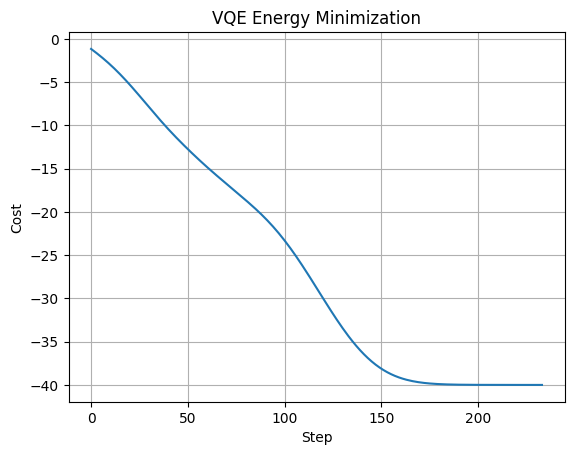

lista_cambios tras VQE: [(9, 0), (7, 1)]
lista_cambios tras eliminar repetidos:  [(7, 1), (9, 0)]
2  - B.4
2  - B.5
3  - B.1
sublista_a_j:  [2, 4]
3  - B.2
combinaciones_delta:  [(8, 2), (8, 4), (0, 4)]
3  - B.3
Step 0 - Cost: -7.1504
Step 200 - Cost: -29.5406
329


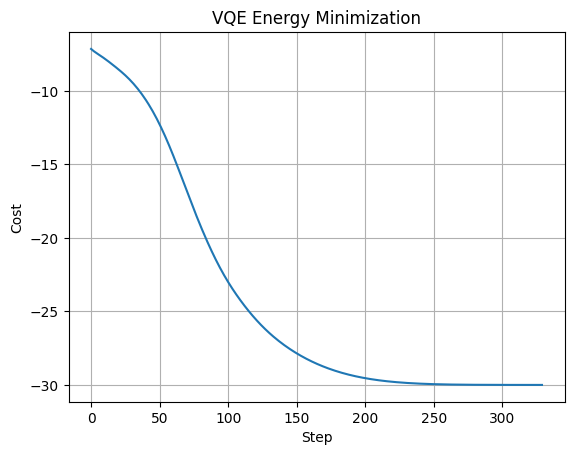

lista_cambios tras VQE: [(8, 2), (0, 4)]
lista_cambios tras eliminar repetidos:  [(0, 4), (8, 2)]
3  - B.4
3  - B.5
5  - B.1
sublista_a_j:  []
5  - B.2
combinaciones_delta:  []


In [96]:
# INICIALIZACIÓN
np.random.seed(3)

# I: Nº de trabajos vacantes
# J: Nº de trabajos ocupados ( = Nº agentes)
I = 5
J = 5
# D: Nº de subdivisiones del problema 
    # En caso discreto = prioridad máxima
D = 5

# cP, cA son los coeficientes de los pesos relativos de los términos de prioridad y afinidad del Hamiltoniano (B.3)
cP = 10
cA = 10

# Si queremos el problema "discreto", "continuo", o "personalizado"
    # SI ES PERSONALIZADO CAMBIAR DESPUÉS A CONTINUO/DISCRETO
tipo = "discreto"

# En caso de que el usuario quiera inicializar por sí mismo los valores
#PC_j_user = # RELLENAR LISTA
#PV_i_user = # RELLENAR LISTA
#A_kj_user = # RELLENAR NP.MATRIX

K, a_j, PC_j, v_i, PV_i, A_kj, dict_trab_prior = inicialización(tipo, J, I, D)
print("a_j: ",a_j)
print("PC_j: ", PC_j)
print("Suma de PC_j: ", sum(PC_j))
print("Suma de afinidades: ", sum([A_kj[p][p] for p in range(len(a_j))]))

asignacion_inicial = a_j.copy()
valor_inicial = sum(PC_j)
satisfaccion_inicial = sum([A_kj[p][p] for p in range(len(a_j))])

print("v_i: ", v_i)
print("PV_i: ", PV_i)
#print("A_kj: ", A_kj)
print("dict_trab_prior: ", dict_trab_prior)

# Si hemos hecho tipo = "personalizado", cambiar a "continuo" o "discreto"
#tipo = #RELLENAR
print("-------------------------------------------------------------------------------------------------")
# -------------------------------------------------------------------------------------------------------------------
# PASO A: CREACIÓN DE LAS D SUBLISTAS
print("A")
if tipo == "continuo":
    limites_sublistas, dict_D_sublistas = crear_dict_D_sublistas_continuo(D, dict_trab_prior, v_i)
else:
    dict_D_sublistas = crear_dict_D_sublistas_discreto(D, dict_trab_prior, v_i)
print("dict_D_sublistas: ", dict_D_sublistas)
# -------------------------------------------------------------------------------------------------------------------
# PASO B: ITERACIONES
# Definimos algunos parámetros para VQE
# Parámetros de las restricciones de 
    # "Cada trabajo i se hace por un agente como mucho"
    # "Cada agente j como mucho reasignado a 1 trabajo"
lambda1 = 20
lambda2 = 20
# Parámetros de AdamOptimizer
    # Pasos en realidad los que queramos, porque si las energías en 5 pasos seguidos son iguales hasta con 4 decimales, es porque ha llegado a un óptimo
    # Pero dejo algunas pruebas por si se quiere acotar
stepsize = [0, 0, 0.01, 0.01, 0.01, 0.005, 0.005, 0.001, 0.001, 0.0005, 0.0005, 0.0001, 0.0001, 0.00005, 0.00005, 0.00001]
steps = 10000 # 500 para 3, 500 para 4, 600 para 5, 1000 para 6, 1500 para 7, 4000 para 8, 6000 para 11

# Iteraciones
for delta in range(1, D+1):
    
    # Si hay algún elemento vacante en el grupo corresondiente
    if len(dict_D_sublistas[delta]) > 0:
        
        # B.1 Quitamos las que no tengan prioridades
        print(delta, " - B.1")
        sublista_a_j = filtro_prioridades(dict_D_sublistas, a_j, dict_trab_prior, delta)
        print("sublista_a_j: ",sublista_a_j)
        
        # B.2 Creamos las combinaciones pertinentes
        print(delta, " - B.2")
        combinaciones_delta = crear_combinaciones(a_j, sublista_a_j, dict_D_sublistas, dict_trab_prior, A_kj, delta)
        print("combinaciones_delta: ", combinaciones_delta)
        
        # Si hay más de 0 combinaciones (si no las hay, saltamos todo lo siguiente y vamos a la siguiente iteración):
        if len(combinaciones_delta) > 0:
            
            # Si hay exactamente una, ejecutamos ese cambio
            if len(combinaciones_delta) == 1:
                lista_cambios = combinaciones_delta
                
            # En otro caso, B.3 VQE
            else:
                print(delta, " - B.3")
                stepsize_value = stepsize[min(len(combinaciones_delta), 16) - 1] 
                lista_cambios = vqe(combinaciones_delta, dict_trab_prior, a_j, A_kj, cP, cA, lambda1, lambda2, stepsize_value, steps)
                print("lista_cambios tras VQE:", lista_cambios)
                lista_cambios = filtrar_pares_sin_repetidos(lista_cambios)
                print("lista_cambios tras eliminar repetidos: ", lista_cambios)
                
            # Por si VQE sugiere no hacer cambios
            if len(lista_cambios) > 0:
                
                # B.4 Actualizar listas de ocupados y vacantes
                print(delta, " - B.4")
                a_j, PC_j, v_i, PV_i = cambios_trabajos(lista_cambios, a_j, v_i, dict_trab_prior, PC_j, PV_i)
                
                # B.5 Actualizamos las sublistas si no es la última iteración (ahorro computacional)
                if delta != D:
                    print(delta, " - B.5")
                    if tipo == "continuo":
                        dict_D_sublistas = actualizar_sublistas_continuo(lista_cambios, dict_trab_prior, limites_sublistas, dict_D_sublistas, delta)
                    else:
                        dict_D_sublistas = actualizar_sublistas_discreto(lista_cambios, dict_trab_prior, dict_D_sublistas, delta)

Al final, devolvemos la lista de trabajos `[a_j]`.

In [97]:
print("Asignación inicial de trabajos: ", asignacion_inicial)
print("Valor inicial de trabajos: ", valor_inicial)
print("Suma de afinidades: ", satisfaccion_inicial)
print("-----------------------------------------------------------------------------")
print("Asignación final de trabajos: ", a_j)
print("Valor final de trabajos: ", sum(PC_j))
print("Suma final de afinidades: ", sum([A_kj[a_j[p]][p] for p in range(len(a_j))]))

Asignación inicial de trabajos:  [0, 1, 2, 3, 4]
Valor inicial de trabajos:  11
Suma de afinidades:  15
-----------------------------------------------------------------------------
Asignación final de trabajos:  [9, 7, 8, 3, 0]
Valor final de trabajos:  18
Suma final de afinidades:  18
